# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




##Importing Kaggle Dataset

In [ ]:
!unzip /content/drive/MyDrive/fresh_rotten_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

##Loading Dataset

In [ ]:
dataset_path = "/content/dataset/train"
dataset_dir = pathlib.Path(dataset_path)
val_path = "/content/dataset/test"
val_dir = pathlib.Path(val_path)

In [ ]:
# list of sub directory(class)
class_names = []
for root, dirs, files in os.walk(dataset_path):
    if len(root) > len(dataset_path):
        x_class = os.path.relpath(root, dataset_path)
        class_names.append(x_class)

print(class_names)

['rottenapples', 'rottenbanana', 'freshbanana', 'freshoranges', 'rottenoranges', 'freshapples']


In [ ]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.png')))
    print(f"Images in class {class_i}:",image_count)

Images in class rottenapples: 2342
Images in class rottenbanana: 2224
Images in class freshbanana: 1581
Images in class freshoranges: 1466
Images in class rottenoranges: 1595
Images in class freshapples: 1693


In [ ]:
# Parameter setting
train_batch = 64
val_batch = 64
img_height = 128
img_width = 128
IMG_SIZE = (img_height, img_width)

In [ ]:
# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch
)

Found 10901 files belonging to 6 classes.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=val_batch
)

Found 2698 files belonging to 6 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


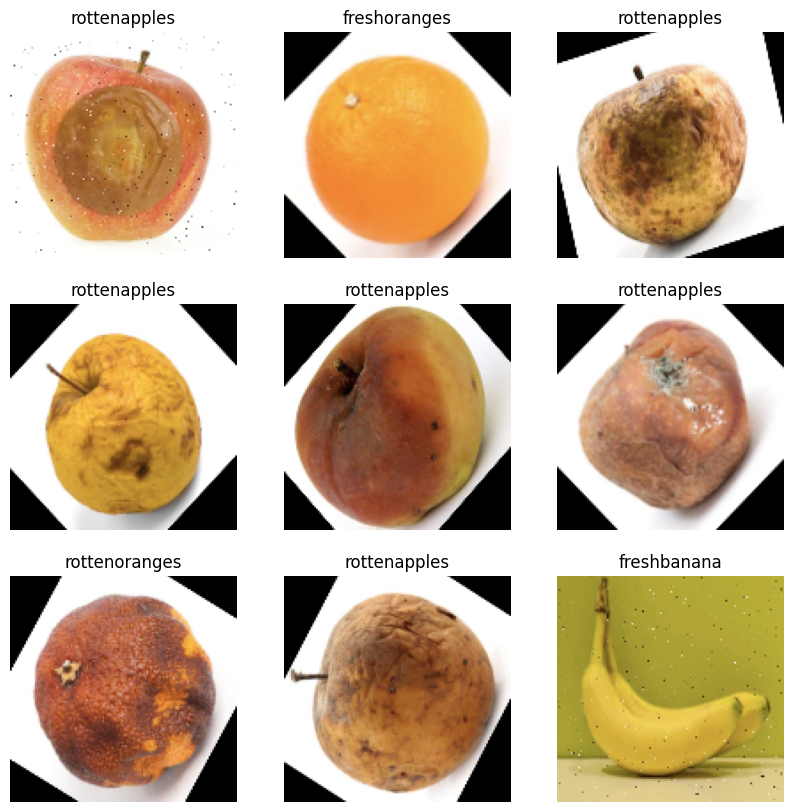

In [ ]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**CNN Model Building**

In [ ]:
#Data augmentation layers to increase data variation for training
data_augmentation = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# compile model
base_learning_rate = 0.0005
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# display model
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         262,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,150 (1.04 MB)

 Trainable params: 272,022 (1.04 MB)

 Non-trainable params: 128 (512.00 B)

##CNN Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
epochs=20
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0,
    callbacks=[early_stopping]
)

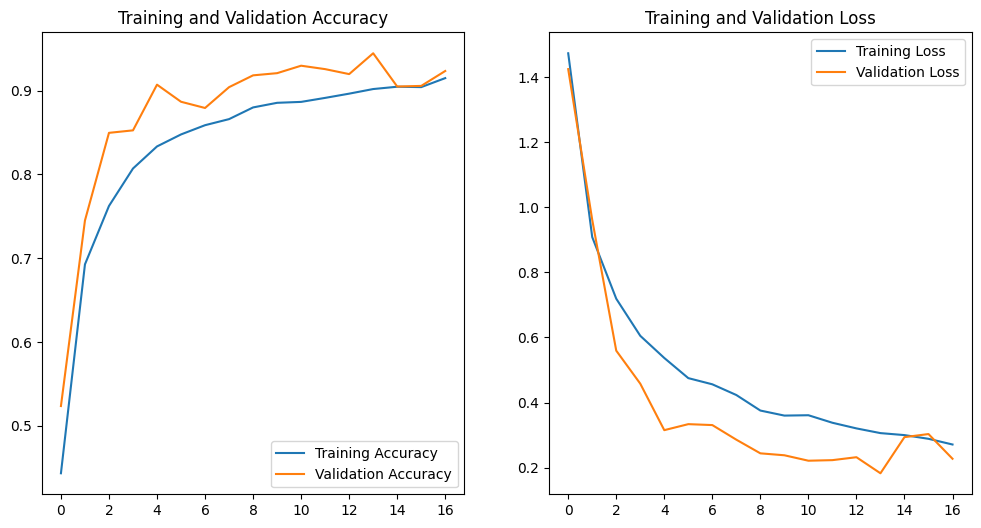

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[:len(acc)], acc, label='Training Accuracy')
plt.plot(epochs_range[:len(val_acc)], val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[:len(loss)], loss, label='Training Loss')
plt.plot(epochs_range[:len(val_loss)], val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Evaluation

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = cnn_model.predict_on_batch(image_batch)

# Convert predictions to class labels
class_predictions = np.argmax(predictions, axis=1)

# Print accuracy and classification report
accuracy = accuracy_score(label_batch, class_predictions)
print(f"Overall Accuracy: {accuracy:.2%}\n")
print("Detailed Classification Report:\n")
print(classification_report(label_batch, class_predictions, target_names=class_names))


Overall Accuracy: 98.44%

Detailed Classification Report:

               precision    recall  f1-score   support

  freshapples       1.00      1.00      1.00         7
  freshbanana       0.91      1.00      0.95        10
 freshoranges       1.00      0.91      0.95        11
 rottenapples       1.00      1.00      1.00        13
 rottenbanana       1.00      1.00      1.00        15
rottenoranges       1.00      1.00      1.00         8

     accuracy                           0.98        64
    macro avg       0.98      0.98      0.98        64
 weighted avg       0.99      0.98      0.98        64



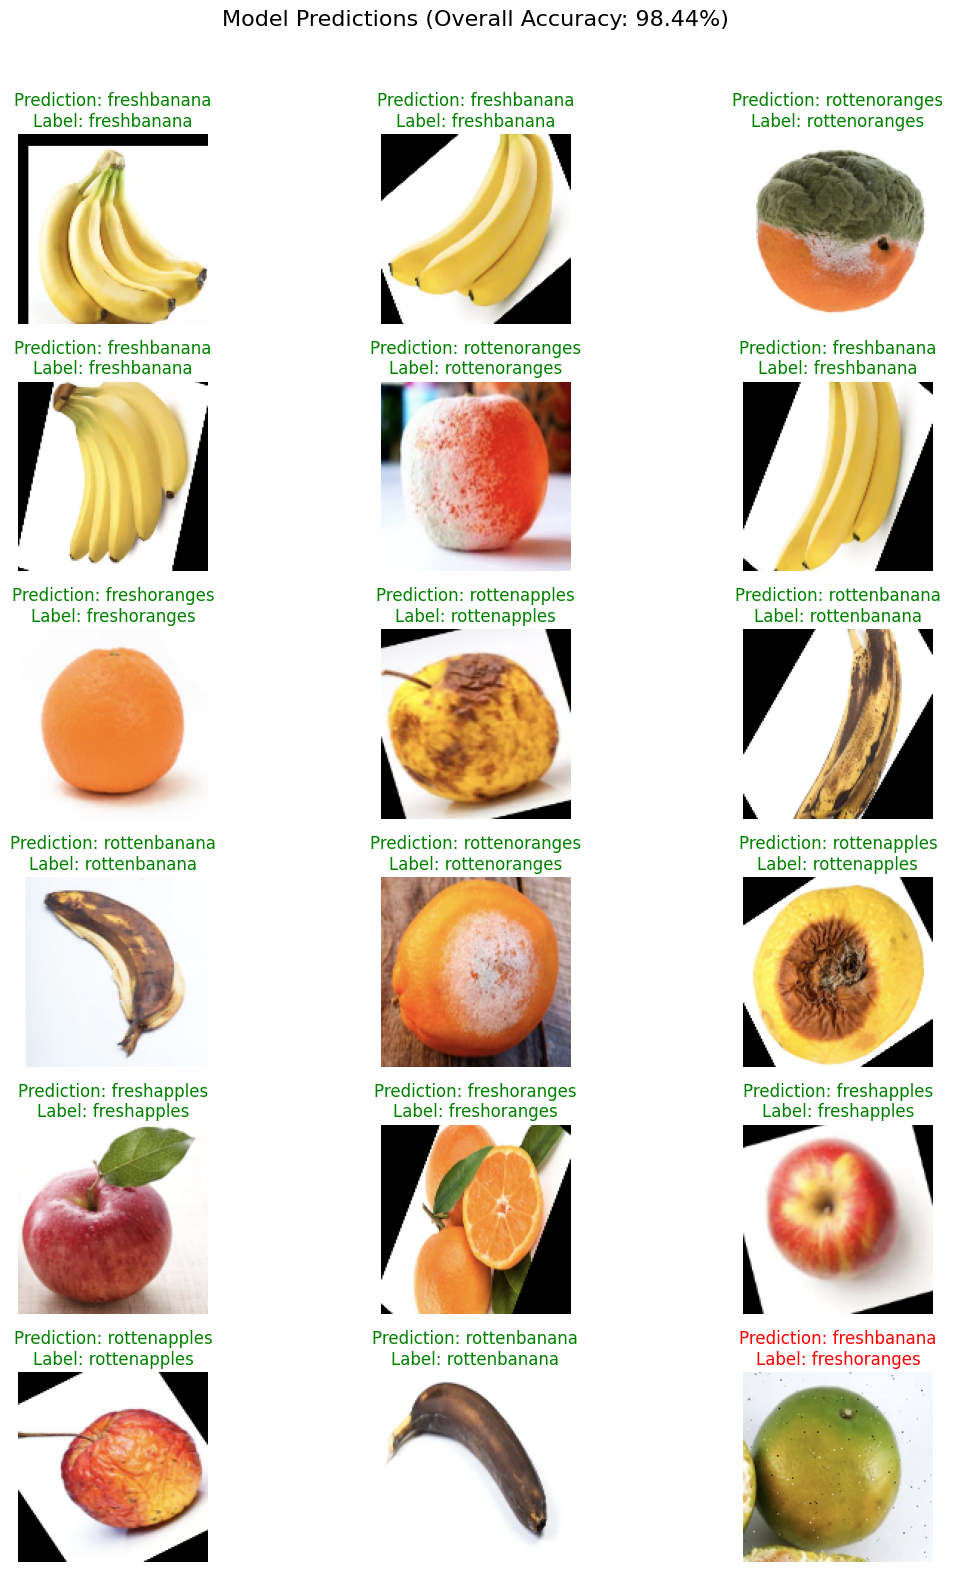

In [ ]:
# Plot sample predictions with titles
plt.figure(figsize=(12, 16))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_label = class_names[class_predictions[i]]
    true_label = class_names[label_batch[i]]
    color = "green" if class_predictions[i] == label_batch[i] else "red"
    plt.title(f"Prediction: {pred_label}\nLabel: {true_label}", color=color)
    plt.axis("off")

plt.suptitle(f"Model Predictions (Overall Accuracy: {accuracy:.2%})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##The CNN Model shows a Testing Accuracy of 98.44%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


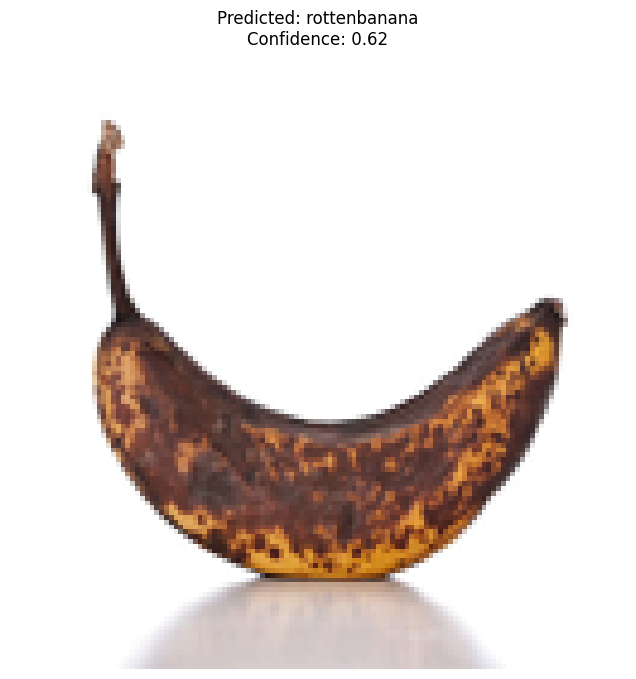

Predicted class: rottenbanana
Confidence: 0.62
Class probabilities:
  freshapples: 0.0145
  freshbanana: 0.0148
  freshoranges: 0.0128
  rottenapples: 0.1255
  rottenbanana: 0.6179
  rottenoranges: 0.2146


In [ ]:
def predict_and_display_image(model, img_path, img_height, img_width, confidence_threshold=0.5):
    class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

    if not os.path.exists(img_path):
        print(f"Error: The file {img_path} does not exist.")
        return
    try:
        with Image.open(img_path) as img:
            img_resized = img.resize((img_width, img_height), Image.BICUBIC)

        img_array = image.img_to_array(img_resized)

        if img_array.shape != (img_height, img_width, 3):
            print(f"Error: Image shape is {img_array.shape}, expected ({img_height}, {img_width}, 3)")
            return

        img_array_for_prediction = np.expand_dims(img_array, axis=0)
        img_array_for_prediction = preprocess_input(img_array_for_prediction)

        predictions = model.predict(img_array_for_prediction)

        predicted_class_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        class_probabilities = {class_name: float(prob) for class_name, prob in zip(class_names, predictions[0])}

        plt.figure(figsize=(8, 8))
        plt.imshow(img_resized)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
        print("Class probabilities:")
        for class_name, prob in class_probabilities.items():
            print(f"  {class_name}: {prob:.4f}")
    except Exception as e:
        print(f"Error occurred: {str(e)}")


predict_and_display_image(cnn_model, '/content/drive/MyDrive/RB1.jpg', img_height, img_width)